# Geneate Configurations of 1D XY model and train RBM on that.

### Its not easy to generate the samples from XY model - we discretize the angles and use potts model instaed.

In [1]:
import sys
import os
sys.path.append('Jerome_scripts_Original/PGM/')
sys.path.append('selfPackages/')
sys.path.append('Jerome_scripts_Original/')
sys.path.append('ffmpeg-3.4.2-32bit-static/')

import numpy as np
import scipy as sc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import rbm
    import bm
except:
    print 'Compiling cy_utilities first'
    curr_dir = os.getcwd()
    os.chdir('PGM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    
import pickle
from ising import IsingModel
import estimate_correlations_ising
from sklearn.utils import shuffle
import inlineMovies

In [90]:
#import dill
#dill.dump_session('./data_bruckner/data/notebookData/32_XYmodel_modified_1D_learningTransition')

In [53]:
import dill
dill.load_session('./data_bruckner/data/notebookData/32_XYmodel_modified_1D_learningTransition')

IOError: [Errno 2] No such file or directory: './data_bruckner/data/notebookData/32_XYmodel_modified_1D_learningTransition'

In [2]:
# Save the data array with the 1d XY model configurations: Expensive to generate over again.
#np.save('./data_bruckner/data/notebookData/data_XY1D_100000_beta1.5_size100_states=10',data)
data = np.load('./data_bruckner/data/notebookData/data_XY1D_100000_beta1.5_size100_states=10.npy')

In [180]:
#%%capture capt1
#Supress the output of the cell and save it to capt1

size = 100
N = size
#beta = 1.5
#Num_configs = [100,300,500,700,800,1000,2000]
#Num_configs = [100,300,500,700,800,1000,2000,3000,4000,5000,8000]
Num_configs = np.append(np.append(np.arange(100,1000,100),np.arange(1000,5000,500)),np.arange(5000,100000,10000))
#Num_configs = [200000]
beta = [1.5]
num_hidden = 1

#Generate spins using Gibbs Sampling MCMC
BM = bm.BM(N=N,nature='Potts',n_c=10)

#Define Couplings
BM.layer.couplings = XY1dCouplingsMF1(BM,size = 100,beta=beta,num_states=10,PBC=True)

In [19]:
print beta

[1.5]


In [168]:
data = BM.gen_data(Nchains=1,Nthermalize=0,Lchains=200000,Nstep=200)
#data = BM.gen_data(Nchains=1,Nthermalize=0,Lchains=np.max(Num_configs),Nstep=200)
#for i in range(len(Num_configs)):
#    data.append(BM.gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs[i],Nstep=200)) # N steps.

KeyboardInterrupt: 

In [3]:
def XY1dCouplings(BM,size=100,beta=1.0,num_states=10,PBC=False):
    
    # This is only the nearest neighbour interactions XY model on a 1D lattcie
    pottsCouplings = np.zeros([num_states,num_states])
    
    for i in np.arange(0,num_states):
        for j in np.arange(0,num_states):
            pottsCouplings[i,j] = np.cos((i-j)*2*np.pi/num_states)
        
    BM.layer.couplings[(np.eye(N=size,k=-1)+np.eye(N=size,k=+1)).astype(bool),:,:] = beta*pottsCouplings
    
    if PBC is True:
        BM.layer.couplings[0,-1] = beta*pottsCouplings
        BM.layer.couplings[-1,0] = beta*pottsCouplings
    
    return BM.layer.couplings

In [170]:
def XY1dCouplingsMF1(BM,size=100,beta=1.0,num_states=10,PBC=False):
    
    # This is only the nearest neighbour interactions XY model on a 1D lattcie
    pottsCouplings = np.zeros([num_states,num_states])
    
    pottsCouplings[np.eye(N=num_states,k=0).astype(bool)] = 1
    pottsCouplings[(np.eye(N=num_states,k=-1) + np.eye(N=num_states,k=+1)).astype(bool)] = 0.8
    
    pottsCouplings[0,-1] = 0.8
    pottsCouplings[-1,0] = 0.8
    
        
    BM.layer.couplings[(np.eye(N=size,k=-1)+np.eye(N=size,k=+1)).astype(bool),:,:] = beta*pottsCouplings
    
    if PBC is True:
        BM.layer.couplings[0,-1] = beta*pottsCouplings
        BM.layer.couplings[-1,0] = beta*pottsCouplings
    
    return BM.layer.couplings

In [15]:
def XY2dCouplings(BM,size=20,beta1=1.0,beta2=1.0,num_states=10,PBC=False):
    
    # This is only the nearest neighbour XY model on a 2D square lattice
    # Calculate the KT transition beta
        
    pottsCouplings = np.zeros([num_states,num_states])
    N = size
    
    for i in np.arange(0,num_states):
        for j in np.arange(0,num_states):
            pottsCouplings[i,j] = np.cos((i-j)*2*np.pi/num_states)
            
    BM.layer.couplings[(np.eye(N=size**2,k=1) + np.eye(N=size**2,k=-1)).astype(bool),:,:] =  beta1*pottsCouplings
    BM.layer.couplings[(np.eye(N=size**2,k=size) + np.eye(N=size**2,k=-size)).astype(bool),:,:] =  beta2*pottsCouplings
    
    # Remove the couplings of the left most coloumn to that of the last coloumn in its previous row:
    for i in np.arange(0,N*N,N):
        BM.layer.couplings[i,i-1] = 0
        BM.layer.couplings[i-1,i] = 0
    
    if PBC is True:
        # Add the couplings of the first row to that of the last row and vice versa:
        for i in np.arange(0,N):
            BM.layer.couplings[i,(size**2)-N+i] = beta2*pottsCouplings
            BM.layer.couplings[(size**2)-N+i,i] = beta2*pottsCouplings
        # Add the couplings of the left most column to the right most coloumn:
            BM.layer.couplings[i,i+N-1] = beta1*pottsCouplings
            BM.layer.couplings[i+N-1,i] = beta1*pottsCouplings
    
    return BM.layer.couplings

In [ ]:
RBM = []
results = []
#data = []
weights = np.zeros([len(beta),len(Num_configs),num_hidden,N,BM.n_c])
topEVec = np.zeros([len(beta),len(Num_configs),N])
overlap = np.zeros([len(beta),len(Num_configs),num_hidden])
overlap_full = np.zeros([len(beta),len(Num_configs),num_hidden])
topEVec_full = np.zeros([len(beta),N])
overlap_proper = np.zeros([len(beta),len(Num_configs),num_hidden,N*BM.n_c])
overlap_proper_full = np.zeros([len(beta),len(Num_configs),num_hidden,N*BM.n_c])
covMATEVEC = np.zeros([len(beta),len(Num_configs),N*BM.n_c,N*BM.n_c])
covMATEVEC_full = np.zeros([len(beta),N*BM.n_c,N*BM.n_c])
covMATEVAL = np.zeros([len(beta),len(Num_configs),N*BM.n_c])
covMATEVAL_full = np.zeros([len(beta),N*BM.n_c])

for j in range(len(beta)):
    
    BM.layer.couplings = XY1dCouplingsMF1(BM,size = 100,beta=beta[j],num_states=10,PBC=True)
    #data.append(BM.gen_data(Nchains=1,Nthermalize=0,Lchains=200000,Nstep=200))
    topEVec_full[j],_ = topEV(data[j].T,method='Correlation')
    _,covMATEVEC_full[j],covMATEVAL_full[j] = corXY(data[j],10,100)

    for i in range(len(Num_configs)):
        
        #Train the model
        RBM.append(rbm.RBM(visible = 'Potts', n_cv=10, n_v=N, n_h = num_hidden, hidden = 'Bernoulli',zero_field = True))
        results.append(RBM[i+j].fit(data[j][0:Num_configs[i]],n_iter=20,verbose=0,learning_rate = 0.1,record=['W'],\
                                  record_interval=100,batch_size=100,N_MC= 20, lr_decay=False,batch_norm=False))

        topEVec[j,i],_ = topEV(data[j][0:Num_configs[i]].T,method='Correlation')
        _,covMATEVEC[j,i],covMATEVAL[j,i] = corXY(data[j][0:Num_configs[i]],10,100)
        
        for k in range(RBM[i].n_h):
            weights[j,i,k]      = np.copy(np.array(results[i+j]['W'])[-1,k,:,:])
            overlap[j,i,k]      = abs(np.dot(np.sum(abs(weights[j,i,k]),axis=1),topEVec[j,i]))
            overlap_full[j,i,k] = abs(np.dot(np.sum(abs(weights[j,i,k]),axis=1),topEVec_full[j]))
            
            for l in range(N*BM.n_c):
                overlap_proper[j,i,k,l]      = np.sum(np.multiply(weights[j,i,k],np.reshape(covMATEVEC[j,i,:,l],[N,BM.n_c])))
                overlap_proper_full[j,i,k,l] = np.sum(np.multiply(weights[j,i,k],np.reshape(covMATEVEC_full[j,:,l],[N,BM.n_c])))

In [ ]:
def cosfit(x,peak,phase,freq):
    return peak*np.cos(x*freq + phase)

popt = np.zeros([len(np.array(results['W'])[:,0,0,0]),RBM.n_h,len(np.array(results['W'])[-1,0,:,0]),3])
popc = np.zeros([len(np.array(results['W'])[:,0,0,0]),RBM.n_h,len(np.array(results['W'])[-1,0,:,0]),3,3])

for i in np.arange(len(np.array(results['W'])[-1,0,:,0])):
    for j in np.arange(len(np.array(results['W'])[:,0,0,0])):
        for k in np.arange(RBM.n_h):
            try:
                popt[j,k,i],popc[j,k,i] = sc.optimize.curve_fit(cosfit,np.arange(10),(np.array(results['W'])[j,k,i,:]),[1,1,2*np.pi/10],bounds=(0,[np.inf,2*np.pi,np.inf]))
            except:
                pass

In [77]:
# Top Eignvectors of the C_ij matrix:
def topEV(data,method='Covariance'):
    if method is 'Covariance':
        #Find the covariance matrix:
        covMAT = np.cov(data)
    elif method is 'Correlation':
        covMAT = np.corrcoef(data)
    Eval,Evec = np.linalg.eig(covMAT)
    return Evec[:,np.argmax(Eval)],np.max(Eval)

In [128]:
def corXY(data,num_configs,num_sites,method='Correlation'):
    
    cov_mat = np.zeros([num_configs*num_sites,num_configs*num_sites])
    
    if method is 'Covariance':
        for i1 in np.arange((num_sites)):
            for j1 in np.arange((num_configs)):
                for i2 in np.arange((num_sites)):
                    for j2 in np.arange((num_configs)):
                        cov_mat[i1*num_configs+j1, i2*num_configs+j2] = \
                        np.float(np.count_nonzero(np.logical_and(data[:,i1]==j1,data[:,i2]==j2)))/(len(data)) \
                        - np.float(np.count_nonzero(data[:,i1]==j1)*np.count_nonzero(data[:,i2]==j2))/(len(data)**2)

    if method is 'Correlation':
        
        diag_mat = np.zeros(num_configs*num_sites)
        
        for i1 in np.arange((num_sites)):
            for j1 in np.arange((num_configs)):
                        diag_mat[i1*num_configs+j1] = \
                        np.float(np.count_nonzero(np.logical_and(data[:,i1]==j1,data[:,i1]==j1)))/(len(data)) \
                        - np.float(np.count_nonzero(data[:,i1]==j1)*np.count_nonzero(data[:,i1]==j1))/(len(data)**2)
        
        for i1 in np.arange((num_sites)):
            for j1 in np.arange((num_configs)):
                for i2 in np.arange((num_sites)):
                    for j2 in np.arange((num_configs)):
                        cov_mat[i1*num_configs+j1, i2*num_configs+j2] = \
                        (np.float(np.count_nonzero(np.logical_and(data[:,i1]==j1,data[:,i2]==j2)))/(len(data)) \
                        - np.float(np.count_nonzero(data[:,i1]==j1)*np.count_nonzero(data[:,i2]==j2))/(len(data)**2)\
                        )/np.sqrt(diag_mat[i1*num_configs+j1]*diag_mat[i2*num_configs+j2])
    
    Eval,Evec = np.linalg.eig(cov_mat)
    
    return cov_mat,Evec,Eval

In [ ]:
overlap_proper = np.zeros([len(beta),len(Num_configs),num_hidden,N*BM.n_c])
overlap_proper_full = np.zeros([len(beta),len(Num_configs),num_hidden,N*BM.n_c])
covMATEVEC = np.zeros([len(beta),len(Num_configs),N*BM.n_c,N*BM.n_c])
covMATEVEC_full = np.zeros([len(beta),N*BM.n_c,N*BM.n_c])
covMATEVAL = np.zeros([len(beta),len(Num_configs),N*BM.n_c])
covMATEVAL_full = np.zeros([len(beta),N*BM.n_c])

for j in range(len(beta)):
    _,covMATEVEC_full[j],covMATEVAL_full[j] = corXY(data,10,100)
    
    for i in range(len(Num_configs)):
        _,covMATEVEC[j,i],covMATEVAL[j,i] = corXY(data[0:Num_configs[i]],10,100)
        
        for k in range(RBM[i].n_h):
            for l in range(N*BM.n_c):
                overlap_proper[j,i,k,l]      = np.sum(np.multiply(weights[j,i,k],np.reshape(covMATEVEC[j,i,:,l],[N,BM.n_c])))
                overlap_proper_full[j,i,k,l] = np.sum(np.multiply(weights[j,i,k],np.reshape(covMATEVEC_full[j,:,l],[N,BM.n_c])))

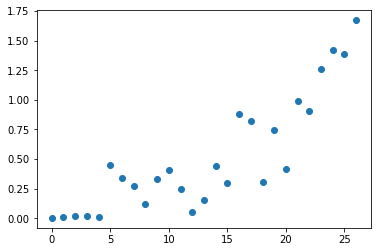

In [137]:
plt.plot(abs(overlap_proper[0,:,0]),'o')

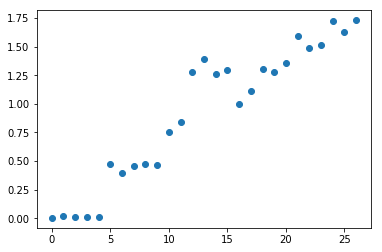

In [144]:
plt.plot(abs(overlap_proper_full[0,:,0]),'o')

In [ ]:
_, covEV,covEval = corXY(data,10,100)

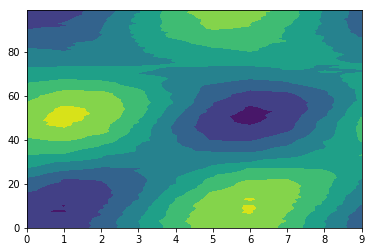

In [160]:
plt.contourf(np.reshape(covEV[:,4],[100,10]))

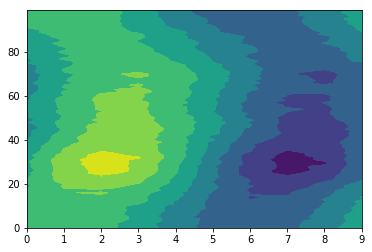

In [134]:
plt.contourf(np.reshape(covMATEVEC_full[-1],[100,10]))

In [202]:
RBM_full = (rbm.RBM(visible = 'Potts', n_cv=10, n_v=N, n_h = num_hidden, hidden = 'Bernoulli',zero_field = True))
results_full = (RBM_full.fit(data[0],n_iter=20,verbose=0,learning_rate = 0.1,record=['W'],\
                                  record_interval=100,batch_size=100,N_MC= 20, lr_decay=False,batch_norm=False))

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20


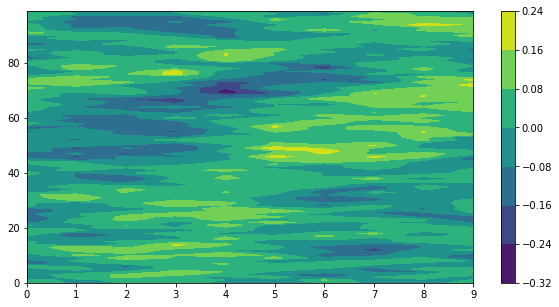

In [209]:
plt.figure(figsize=(10,5))
plt.contourf(np.array(results_full['W'])[-1,0,:,:])
plt.colorbar()

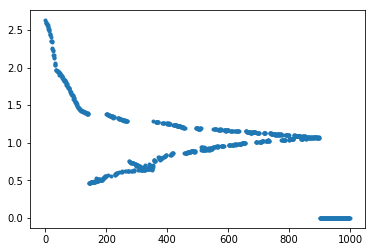

In [182]:
plt.plot(covMATEVAL_full[0],'.')

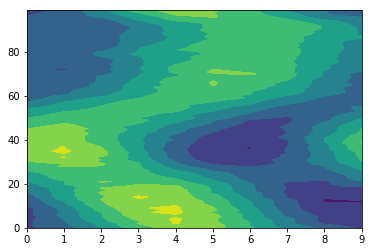

In [214]:
plt.contourf(np.reshape(covMATEVEC_full[0,:,0],[100,10]))

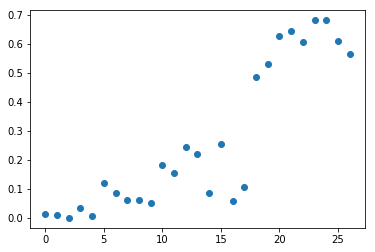

In [199]:
plt.plot(abs(overlap_proper_full[0,:,0,2]),'o')

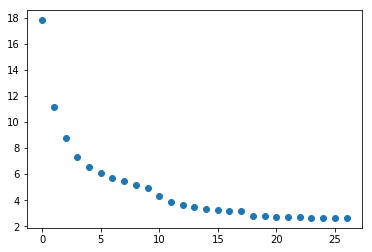

In [210]:
plt.plot(covMATEVAL[0,:,0],'o')